安装成功测试

In [1]:
import tensorflow as tf

简单的两个数组相加案例

In [2]:
a = tf.constant([1,2], name='a')
b = tf.constant([3,4], name='b')
result = a + b
sess = tf.Session()
sess.run(result)  

array([4, 6])

# 3 Basic
---
1. 计算模型 - 计算图
2. 数据模型 - tensor
3. 运行模型 - session
4. 计算流程

## 3.1 计算图的使用
---
**tensorflow**,其中tensor代表张量也就是多维数组，而flow本意是流，用来展现tensor的转换关系。这么一个关系就构成了简单的图。

TensorFlow程序的运行一般分为**两个阶段**。
- 定义计算图中的计算(包括tensor，计算过程)
- 执行计算(需要在Session中执行)

在tensorflow程序中，会有一个默认的计算图，如果不特意指定，我们所有的操作都是在这个默认的计算图中操作。可以通过`tf.get_default_graph()`获取默认计算图。也可以使用`tf.Graph()`创建新的计算图。**各个计算图相互独立**。

```python
import tensorflow as tf

# 获取默认计算图
tf.get_default_graph()

# 创建新的计算图
g1 = tf.Graph()

# 指定操作的计算图
with g1.as_default():
    # 指定计算图的运行设备
    with g1.device('/gpu:0'):
        # 计算过程
        pass
    
        # 执行阶段指定要执行的计算图
        with tf.Session(graph=g1) as sess:
            sess.run(...)
```

In [5]:
# 创建两个计算图，并定义一个初始化变量v
g1 = tf.Graph()
with g1.as_default():
    v = tf.get_variable('v', shape=[1], initializer=tf.zeros_initializer)
    
g2 = tf.Graph()
with g2.as_default():
    v = tf.get_variable('v', shape=[1], initializer=tf.ones_initializer)
    
# 获取g1中的v
with tf.Session(graph=g1) as sess:
    tf.global_variables_initializer().run()
    with tf.variable_scope('', reuse=True):
        print('Graph1 v = ', sess.run(tf.get_variable('v')))

# 获取g2中的v
with tf.Session(graph=g2) as sess:
    tf.global_variables_initializer().run()
    with tf.variable_scope('', reuse=True):
        print('Graph2 v = ', sess.run(tf.get_variable('v')))

Graph1 v =  [0.]
Graph2 v =  [1.]


指定图在GPU计算

In [9]:
g = tf.Graph()
a = tf.constant([1,2], name='a')
b = tf.constant([3,4], name='b')

with g.device('/gpu:0'):
    result = a + b
    with tf.Session() as sess:
        print(sess.run(result))

[4 6]


> Collection

为方便管理一个计算图中的所有资源，tensorflow引入了Collection来管理不同的资源。详情查看(`help(tf.GraphKeys)`),包含了已经定义好的集合和属性。可以使用`tf.add_to_collection(key_name, values)`将value加入到指定名称的集合中,使用`tf.get_collection(key_name)`获取指定集合名称的值。

先写一个集合的用法**eg**
```python
# 将[1,2,3,4]加入到GLOBAL_VARIABLES
tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, [1,2,3,4]) # 或者tf.add_to_collection('variables', [1,2,3,4])

# 获取GLOBAL_VARIABLES集合中的内容
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) # 或者tf.get_collection('variables') 或者tf.global_variables()
```

其中已经定义号的集合名称，并且可以直接通过`tf.`列举常用的key有：

|variable_name|variable_value|noters|
|---|---|---|
|GLOBAL_VARIABLES|variables|default collection of variable|
|MODEL_VARIABLES|model_variables|use in the model for **inference**|
|TRAINABLE_VARIABLES|trainable_variables|will be trained by **optimizer**|
|SUMMARIES|summaries|the summary tensor objects that have been created|
|QUEUE_RUNNERS|queue_runners|used to product input for a computation|
|MOVING_AVERAGE_VARIABLES|moving_average_variables|for moving_averages|
|REGULARIZATION_LOSSES|regularization_losses|regulation losses collected|


## 3.2 Tensor
---
### 3.2.1 introduction
---
张量在tensorflow中代表的是一个数据结构，保留的是计算过程，并不直接保存计算结果。如果想要获得结果需要先对相关变量进行初始化，并在会话中获取结果。
1. tensor
    - 0阶张量为标量(scalar)，对应一个数
    - 一阶张量为向量(vector)，对应一维数组
    - n阶张量对应n维数组
2. tensor的数据结构
    - name: `name:src_output`
    - shape:
    - dtype: 默认为tf.int32和tf.float32
3. tensor支持的数据类型
    - tf.float32, tf.float64
    - tf.int8, tf.int16, tf.int32, tf.int64, tf.uint8
    - tf.bool
    - tf.complex64, tf.complex128
4. 张量的使用
    - 对中间计算结果的引用
    - 可以通过name获取保存的计算结果

In [20]:
a = tf.constant([1,2], name='a')
b = tf.constant([3,4], name='b')
result = tf.add(a, b, name='add_ab')

## 3.3 Session
---
tensorflow 通过使用Session来执行定义好的运算。
```python
sess = tf.Session()
# 执行定义好的张量
sess.run()

sess.close()
```
or
```python
with tf.Session() as sess:
    sess.run()
```

### 3.3.1 定义默认会话
---


**方法1**：使用as_default创建一个context manager，在内部可以直接使用tensor_name.eval()执行。

In [83]:
# 使用as_default创建一个context manager，在内部可以直接使用tensor_name.eval()执行。
sess = tf.Session()
with sess.as_default():
    print(result.eval())

[4 6]


**方法2**：(常用于交互环境)使用`tf.InteractiveSession()`函数,直接创建一个session并设为默认sessio。

In [86]:
sess = tf.InteractiveSession()
print(result.eval())

sess.close()

[4 6]


**方法3**：使用`ConfigProto()`创建一个config对象，在session创建的时候指定config属性

In [89]:
config = tf.ConfigProto(allow_soft_placement=True,
                       log_device_placement=True)

sess1 = tf.InteractiveSession(config=config)
# sess2 = tf.Session(config=config)

## 3.4 实现神经网络
---
主要介绍实现神经网络的前向传播过程。输入层到隐藏层到输出层。

In [100]:
x = tf.constant([0.7, 0.9], shape=(2, 1))

In [101]:
w1 = tf.constant([[0.2, 0.3],[0.1,-0.5],[0.4,0.2]], shape=(3, 2))

In [102]:
w2 = tf.constant([0.6, 0.1, -0.2], shape=(1, 3))

In [103]:
a = tf.matmul(w1, x)
y = tf.matmul(w2, a)

In [104]:
y.eval()

array([[0.11600002]], dtype=float32)

### 1.4.1 variable
---
在tensorflow中，一个变量值在被使用之前，这个变量的**初始化过程**要被明确调用。变量定义类似于python中的函数定义，想要使用，需要调用。通过session调用。
```python
# 创建variable,并将变量加入到GraphKeys.VARIABLES,如果参数trainable=True,默认为True,则变量会被加入到GraphKeys.TRAINABLE_VARIABLES
v = tf.Variable()
# 初始化
v.initializer

# 获取已定义的变量列表
tf.global_variables()

# 获取可训练的变量列表
tf.trainable_variables

```

>  随机生成函数
---
```python
tf.random_normal
tf.truncated_normal
tf.random_uniform
tf.random.gamma
```

> 常数生成函数
---
```python
tf.zeros
tf.ones
tf.fill
tf.constant
```
### 1.4.2 前向传播
---
1. 定义输入值
2. 定义隐藏层1的权重
3. 定义隐藏层2的权重
4. 计算

In [1]:
import tensorflow as tf

# 定义输入值
x = tf.constant([0.7,0.9], shape=(1, 2), dtype=tf.float32)

# 随机生成权重值，采用正太分布
w1 = tf.Variable(tf.random_normal((2, 3), stddev=1, seed=1))
w2 = tf.Variable(tf.random_normal((3, 1), stddev=1, seed=1))

# 定义计算过程
h = tf.matmul(x, w1)
y = tf.matmul(h, w2)

# 定义全局变量初始化
init_op = tf.global_variables_initializer()

# 开始计算
with tf.Session() as sess:
#     sess.run(w1.initializer)
#     sess.run(w2.initializer)
    sess.run(init_op)
    print(sess.run(y))

[[3.957578]]


### 1.4.3 placeholder
---
用于训练模型的输入值。通过placeholder起到一个占位的作用，需要定义shape，和dtype。在执行过程中通过feed_dict传值。
```python
# 创建
v = tf.placeholder(dtype, shape=None, name=None)
```

In [3]:
import tensorflow as tf

# 定义输入值
x = tf.placeholder(tf.float32, shape=(2, 1), name='input')

# 随机生成权重值，采用正太分布
w1 = tf.Variable(tf.random_normal((3, 2), stddev=1, seed=1))
w2 = tf.Variable(tf.random_normal((1, 3), stddev=1, seed=1))

# 定义计算过程
h = tf.matmul(w1, x)
y = tf.matmul(w2, h)

# 定义全局变量初始化
init_op = tf.global_variables_initializer()

# 开始计算
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(y, feed_dict={x: [[0.7],[0.9]]}))

[[-3.7798672]]


定义多维输入值,这里定义三个样本

In [8]:
import tensorflow as tf
import numpy as np

# 定义输入值（三个样本）
x = tf.placeholder(tf.float32, shape=(2, 3), name='input')

# 随机生成权重值，采用正太分布
w1 = tf.Variable(tf.random_normal((3, 2), stddev=1, seed=1))
w2 = tf.Variable(tf.random_normal((1, 3), stddev=1, seed=1))

# 定义计算过程
h = tf.matmul(w1, x)
y = tf.matmul(w2, h)

# 定义全局变量初始化
init_op = tf.global_variables_initializer()

# 定义输入值
input_data = np.array([[0.7, 0.9],
                      [0.1, 0.4],
                      [0.5, 0.8]]).T
# 开始计算
with tf.Session() as sess:
    sess.run(init_op)
    print(sess.run(y, feed_dict={x: input_data}))

[[-3.7798674 -1.8407464 -3.4529805]]


### 1.4.4 反向传播
---
这里采用交叉熵
$$H(p,q)=-\sum_{i=1}^np(x_i)log(q(x_i))$$
其中p为target值的概率，q为预测值的概率

In [2]:
16%100

16

### 1.4.5 完整的代码
---

In [10]:
import tensorflow as tf
import numpy as np

# 定义batch的大小
batch_size = 8

# 定义输入值,这里不具体指定样本的数量
x = tf.placeholder(tf.float32, shape=(None, 2), name='input')
# 定义输出的label
y_ = tf.placeholder(tf.float32, shape=(None, 1), name='target')

# 随机生成权重值，采用正太分布
w1 = tf.Variable(tf.random_normal((2, 3), stddev=1, seed=1))
w2 = tf.Variable(tf.random_normal((3, 1), stddev=1, seed=1))

# 定义计算过程
h = tf.matmul(x, w1)
y = tf.matmul(h, w2)

# 对输出结果归一化处理
y = tf.sigmoid(y)


# 求交叉熵，衡量误差
cross_entropy = -tf.reduce_mean(
    y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0)) + (1 - y_) * tf.log(tf.clip_by_value(1 - y, 1e-10, 1.0))
)

train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

# 随机生成模拟数据集
rdm = np.random.RandomState(1)
dataset_size = 128
X = rdm.rand(dataset_size, 2)

# 确定target
Y = [[int(x1 + x2 < 1)] for (x1, x2) in X]

with tf.Session() as sess:   
    # 定义全局变量初始化
    init_op = tf.global_variables_initializer()
    
    sess.run(init_op)
    print('w1-->\n', sess.run(w1))
    print('w2-->\n', sess.run(w2))

    steps = 5000
    for i in range(steps):
        start = (i * batch_size) % dataset_size
        end = min(start + batch_size, dataset_size)
        sess.run(train_step, feed_dict={x: X[start: end], y_: Y[start: end]})
        
        if i % 1000 == 0:
            total_cross_entropy = sess.run(cross_entropy, feed_dict={x: X, y_: Y})
            print('After %d , cross entropy is %g' % (i, total_cross_entropy))
    print('new w1\n', sess.run(w1))
    print('new w2\n', sess.run(w2))

w1-->
 [[-0.8113182   1.4845988   0.06532937]
 [-2.4427042   0.0992484   0.5912243 ]]
w2-->
 [[-0.8113182 ]
 [ 1.4845988 ]
 [ 0.06532937]]
After 0 , cross entropy is 1.89805
After 1000 , cross entropy is 0.655075
After 2000 , cross entropy is 0.626172
After 3000 , cross entropy is 0.615096
After 4000 , cross entropy is 0.610309
new w1
 [[ 0.02476974  0.56948686  1.6921943 ]
 [-2.1977353  -0.23668927  1.1143897 ]]
new w2
 [[-0.45544702]
 [ 0.49110925]
 [-0.98110336]]


# 4 深层NN
---
1. 深度学习与深层神经网络的概念。
2. 设定神经网络优化目标(损失函数)-分类问题和回归问题
3. 神经网络反向传播算法
4. 神经网络优化

## 4.1 常用的非线性激活函数
---
**ReLU函数**
$$f(x) = max\{x, 0\}$$

**sigmoid函数**
$$f(x) = \frac{1}{1 + e^{-x}}$$

**tanh函数**
$$f(x) = \frac{1 - e^{-2x}}{1 + e^{-2x}}$$

```python
tf.nn.relu()
tf.nn.sigmoid()
tf.nn.tanh()
```

## 4.2 损失函数
---
1. 分类问题
    - 交叉熵
        - 先用softmax将输出结果转成概率分布的形式`tf.nn.softmax()`
        - $$H(p, q) = - \sum_xp(x)log q(x)$$
        - p为正确答案的概率分布，q为预测答案的概率分布，这里都可以用概率表示。整体的意义为用q的概率分布来表示p的概率分布的困难程度。
        - p和q越接近，交叉熵的值越小。
        ```python
        # softmax + cross_entropy
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
        # 只有一个正确答案的分类问题
        tf.nn.softmax_sparse_softmax_cross_entropy_with_logits()
        ```
        $$softmax(y)_i = \frac{e^{y_i}}{\sum_{j=1}^ne^{y_j}}$$
2. 回归问题
    - MSE(mean squared error)
    - $$MSE(y, y^{'}) = \frac{\sum_{i=1}^{n}(y_i - y_i^{'})^2}{n}$$
    - MSE也常用于分类问题的损失函数
    - `tf.reduce_mean(tf.square(y_ - y))`
3. 自定义

## 4.3 神经网络优化算法
---
梯度下降算法主要用于优化单个参数的取值，而反向传播算法给出了一个高效的方式在所有的参数上使用梯度下降算法。

神经网络的优化过程可以分为两个阶段。
1. 先通过前向传播算法得到预测值，并将预测值和实际值做对比得到两者之间的差距。
2. 通过反向传播算法计算损失函数对每一个参数的梯度，再根据梯度和学习率使用梯度下降算法更新每一个参数。

梯度下降算法存在的不足：
1. 不一定能达到全局最优。
2. 计算时间太长。

为了解决计算时间太长的问题，提出**随机梯度下降算法**，这个算法在每一轮的迭代中，随机优化某一条训练数据上的损失函数。缺点是因为减少了权重跟新的数量，可能无法达到局部最优。

为了衡量**梯度下降算法**和**随机梯度下降算法**的优缺点，我们通常会在每一轮训练中，训练一小部分的训练数据，也就是一个batch。

## 4.4 网络进一步优化
---
### 1. 学习率
- **指数衰减法**

通过指数衰减法的学习率既可以让模型在训练的前期快速接近较优解，又可以保证在训练的后期不会有太大的波动，从而更加接近局部最优。
```python
    decayed_learning_rate = learning_rate *
                    decay_rate ^ (global_step / decay_steps)
```
- learning_rate:学习率，dency_rate:衰减率，global_step:迭代次数，常为一个数值为0的tensor。decay_steps:衰减速度。eg:每迭代100000次，学习率乘以0.96
```python
...
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.GradientDescentOptimizer(learning_rate)
    .minimize(...my loss..., global_step=global_step)
)
```
- 对应tf中的函数为：`tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name=None)`
    - staircase为False，表示连续衰减
    - staircase为True，表示阶梯衰减。
    
### 2. 过拟合
- 正则化。正则化是处理过拟合常用的方法。**正则化是针对权重进行操作的**
- L1正则化$$R(w) = \lVert{w}\rVert_1 = \sum_i\lvert{w_i}\rvert$$
- L2正则化$$R(w) = \lVert{w}\rVert_1^2 = \sum_i\lvert{w_i^2}\rvert$$
- L1和L2同时使用：$$R(w) = \sum_i\alpha\lvert{w_i}\rvert + (1 - \alpha)w_i^2$$
- 如果损失函数为$J(\theta)$加入了正则化后，加会变成$J(\theta) + \lambda{R(w)}$
- eg
```python
weights = tf.constant([[1.0, -2.0],[-3.0, 4.0]])
with tf.Session() as sess:
    print(sess.run(tf.contrib.layers.l1_regularizer(0.5)(weights)))
    print(sess.run(tf.contrib.layers.l2_regularizer(0.5)(weights)))
    print(sess.run(tf.contrib.layers.l1_l2_regularizer(0.5)(weights)))
```

下一个五层神经网络(3个隐藏层)，带有L2正则化的实现方法。(只是部分实现代码，不做具体实现)

In [55]:
import tensorflow as tf

# 这里传入一个shape，随机生成一组权重值，并以lambda和权重值得到L2，并加入到tf的collection中
def get_weight(shape, lamb):
    # 依据给定的shape生成一组正太分布随机值
    weights = tf.Variable(tf.random_normal(shape), dtype=tf.float32)
    # 计算L2
    L2 = tf.contrib.layers.l2_regularizer(lamb)(weights)
    tf.add_to_collection('losses', L2)
    return weights

# 定义输入值
x = tf.placeholder(tf.float32, shape=(None, 2))
# 定义target值结构
y_ = tf.placeholder(tf.float32, shape=(None, 1))

batch_size = 8
# 定义每一层的节点数
layer_dimension = [2, 10, 10, 10, 1]
# 层数
n_layers = len(layer_dimension)

# 定义所在计算层
cur_layer = x
in_dimension = layer_dimension[0]

for i in range(1, n_layers):
    # 获取第一层的weights，先确定shape
    out_dimension = layer_dimension[i]
    weight = get_weight((in_dimension, out_dimension), 0.01)
    # 更新当前层的输出值
    bias = tf.Variable(tf.constant(0.1, shape=(out_dimension, 1)))
    cur_layer = tf.matmul(cur_layer, weight) + bias
    in_dimension = out_dimension
    
# 求损失函数，MSE
mse_loss = tf.reduce_mean(tf.square(y_ - cur_layer))
tf.add_to_collection('losses', mse_loss)

# 
loss = tf.add_n(tf.get_collection('losses'))

## ing


### 3. 滑动平均模型（对所有训练参数操作）
- 在每层的计算中，对权重和偏移量计算一个滑动平均(也理解为对所有神经网络参数的变量上使用滑动平均)
- (可以使模型在测试数据上更加的robust).
- 适用于**随机梯度下降**训练神经网络时
- `tf.train.ExponentialMovingAverage(decay, num_updates=None, zero_debias=False, name='ExponentialMovingAverage')`
    - decay越大模型越趋于稳定。


In [59]:
# 实现移动平均模型
import tensorflow as tf

# 创建一个要滑动平均的变量
v1 = tf.Variable(0, dtype=tf.float32)

# 创建一个维护迭代次数的变量
step = tf.Variable(0, trainable=False)

# 初始化一个滑动平均类
ema = tf.train.ExponentialMovingAverage(0.99, step)

# 定义一个变量滑动更新的列表，每次执行这个操作时，列表中的值都会被更新。
maintain_average_op = ema.apply([v1])

with tf.Session() as sess:
    # 对创建的变量进行初始化操作
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    # 通过ema.average(v1)获取滑动平均之后的取值，该变量名要在之前的更新列表中
    # 由于还没有执行maintain_average_op，所以变量还没有更新
    print('v1=0,step=0')
    print(sess.run([v1, ema.average(v1)]))
    
    # 把v1的值设为5，执行一次maintain_average_op，v1滑动一次
    sess.run(tf.assign(v1, 5))
    sess.run(maintain_average_op)
    print('\nv1=5,step=0')
    print(sess.run([v1, ema.average(v1)]))
    
    # 改变step和v1，执行maintain_average_op，v1滑动一次
    sess.run(tf.assign(step, 1000))
    sess.run(tf.assign(v1, 10))
    sess.run(maintain_average_op)
    print('\nv1=10,step=1000')
    print(sess.run([v1, ema.average(v1)]))
    
    # v1再滑动一次
    print('\nv1=10, step=1000')
    sess.run(maintain_average_op)
    print(sess.run([v1, ema.average(v1)]))     
          

v1=0,step=0
[0.0, 0.0]

v1=5,step=0
[5.0, 4.5]

v1=10,step=1000
[10.0, 4.555]

v1=10, step=1000
[10.0, 4.60945]


## 知识点
---
1. **sigmoid** 是非线性激活函数，常用的非线性激活函数还有**tanh**和**ReLU**
2. **softmax回归**用于将神经网络的前向传播结果变成一个**概率分布**。
3. **梯度下降算法**是更新单个节点权重，**反向传播算法**是实现对所有的节点更新权重，**随机梯度下降算法**是为解决梯度下降算法运行时间过长的问题。
4. 学习率优化，过拟合，滑动平均都是对神经网络的进一步优化。学习率优化常采用**指数衰减学习率**的方法。针对过拟合采用**正则化**的方法。采用**滑动平均**对训练参数进行优化。

# 5 MNIST
---
该数据集包含三部分：训练集、验证集、测试集。

In [15]:
# 从指定路径获取数据集，或者将数据集下载到指定路径
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('D:/softfiles/workspace/data/tensorflow/data/', one_hot=True)

Extracting D:/softfiles/workspace/data/tensorflow/data/train-images-idx3-ubyte.gz
Extracting D:/softfiles/workspace/data/tensorflow/data/train-labels-idx1-ubyte.gz
Extracting D:/softfiles/workspace/data/tensorflow/data/t10k-images-idx3-ubyte.gz
Extracting D:/softfiles/workspace/data/tensorflow/data/t10k-labels-idx1-ubyte.gz


## 5.1 完整案例
---
优化代码详见以下文件：
- `mnist_inference.py`
- `mnist_train.py`
- `mnist_eval.py`

In [5]:
import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 定义各层的节点数，这里只使用一个隐藏层
# 输入层节点数，每个图片的像素为28 * 28
INPUT_NODES = 28 * 28

# 输出层节点数
OUTPUT_NODES = 10

# 隐藏层节点数
HIDDEN_NODES = 500

# 定义每轮训练的样本数量
BATCH_SIZE = 100

# 定义滑动平均参数
MOVING_AVERAGE_DECAY = 0.99

# 定义正则化参数
REGULARIZATION_RATE = 0.0001


# 定义学习率优化参数
# 学习率
LEARNING_RATE_BASE = 0.8
# 下降率
LEARNING_RATE_DECAY = 0.99

# 训练次数
TRAINING_STEPS = 10000

# 获取预测值，如果没有avg_class即滑动平均类，则直接计算输出，最后一层输出不用再激活，会在损失函数计算中
# 一起计算。如果给了滑动平均类，则对添加进更新列表中的参数执行一次滑动平均。
def getFinalOutput(input_tensor, weights1, biases1, weights2, biases2, avg_class=None):
    if avg_class == None:
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
        return tf.matmul(layer1, weights2) + biases2
    else:
        layer1 = tf.nn.relu(tf.matmul(input_tensor, avg_class.average(weights1)) + avg_class.average(biases1))
        return tf.matmul(layer1, avg_class.average(weights2)) + avg_class.average(biases2)


# 训练
def train(mnist):
    # 定义输入值和输出值
    x = tf.placeholder(tf.float32, shape=(None, INPUT_NODES), name='input')
    y_ = tf.placeholder(tf.float32, shape=(None, OUTPUT_NODES), name='output')
    
    # 初始化权重和偏移量
    weights1 = tf.Variable(tf.truncated_normal((INPUT_NODES, HIDDEN_NODES), stddev=0.1))
    biases1 = tf.Variable(tf.constant(0.1, shape=(HIDDEN_NODES,)))
    
    weights2 = tf.Variable(tf.truncated_normal((HIDDEN_NODES, OUTPUT_NODES), stddev=0.1))
    biases2 = tf.Variable(tf.constant(0.1, shape=(OUTPUT_NODES,)))
    
    # 定义一个没有滑动平均的输出值
    output = getFinalOutput(x, weights1, biases1, weights2, biases2)
    
    # 创建滑动平均类
    GLOBAL_STEP = tf.Variable(0, trainable=False)
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, GLOBAL_STEP)
    # 这里把所有的trainable变量加入到滑动平均类更新列表中
    variable_averages_op = variable_averages.apply(tf.trainable_variables())
    
    # 获取滑动平均的预测
    average_output = getFinalOutput(x, weights1, biases1, weights2, biases2, variable_averages)
    
    # 计算损失函数交叉熵+softmax
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
    # 防止过拟合，添加正则项，这里只对权重操作，
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    regularization = regularizer(weights1) + regularizer(weights2)
    
    # 最终损失函数
    loss = cross_entropy_mean + regularization
    
    # 定义衰减学习率(指数衰减法)
    LEARNING_RATE = tf.train.exponential_decay(LEARNING_RATE_BASE, GLOBAL_STEP, mnist.train.num_examples / BATCH_SIZE, LEARNING_RATE_DECAY)
    
    # 梯度下降更新权重值
    gdo = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    train_step = gdo.minimize(loss, global_step = GLOBAL_STEP)
    
    # 打包更新操作，这里有两个动作，train_step,variable_averages_op
    with tf.control_dependencies([train_step, variable_averages_op]):
        train_op = tf.no_op(name='train')
    
    # 输出正确率
    correct_predict = tf.equal(tf.argmax(average_output, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32))
    
    # 初始会话
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        validate_feed = {x: mnist.validation.images, y_: mnist.validation.labels}
        test_feed = {x: mnist.validation.images, y_: mnist.validation.labels}
        for i in range(TRAINING_STEPS):
            if i % 1000 == 0:
                validate_acc = sess.run(accuracy, validate_feed)
                print('After %d training steps, validation accuracy using average model is %g' % (i, validate_acc))
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_op, feed_dict={x: xs, y_: ys})
        
        test_acc = sess.run(accuracy, test_feed)
        print('After %d training steps, test accuracy using average model is %g' % (TRAINING_STEPS, test_acc))
    

def main(argv=None):
    mnist = input_data.read_data_sets('D:/softfiles/workspace/tensorflow/data/', one_hot=True)
    train(mnist)
    return 0

if __name__ == '__main__':
    


Extracting D:/softfiles/workspace/tensorflow/data/train-images-idx3-ubyte.gz
Extracting D:/softfiles/workspace/tensorflow/data/train-labels-idx1-ubyte.gz
Extracting D:/softfiles/workspace/tensorflow/data/t10k-images-idx3-ubyte.gz
Extracting D:/softfiles/workspace/tensorflow/data/t10k-labels-idx1-ubyte.gz
After 0 training steps, validation accuracy using average model is 0.1116
After 1000 training steps, validation accuracy using average model is 0.9792
After 2000 training steps, validation accuracy using average model is 0.9818
After 3000 training steps, validation accuracy using average model is 0.9828
After 4000 training steps, validation accuracy using average model is 0.9834
After 5000 training steps, validation accuracy using average model is 0.9838
After 6000 training steps, validation accuracy using average model is 0.984
After 7000 training steps, validation accuracy using average model is 0.9842
After 8000 training steps, validation accuracy using average model is 0.9846
After

SystemExit: 0

D:\softfiles\programs\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 5.2 使用验证数据集判断模型
---
在进行模型训练开始之前我们需要设定参数的取值，如何确定这些取值，如果直接采用训练数据，会出现过度拟合的情形，所以这就是验证数据集的作用，通过使用验证数据集对各参数的取值进行验证，以得到最优参数范围。除了使用验证数据集，我们也可以使用**交叉验证**的方法来进行参数选择，但是交叉验证效率较低。

1. 从训练数据中选取一部分做验证数据。
2. 采用cross validation(对于大批量数据耗时交久，因为交叉验证常会测试多次)

## 5.3 变量管理
---
这里引入了scope的概念，进一步优化变量的管理，通过使用scope，可以指定变量的所属域，可以通过参数reuse决定是创建变量还是引用变量。**reuse**很重要。get_variable创建变量时，必须先指定域名和变量名，shape，initializer
### 创建变量
```python
tf.get_variable(name, shape, initializer) # 创建或获取
tf.Variable()
```


### 获取变量
```python
tf.get_variable(name) # 要配合tf.variable_scope(name, reuse)生成一个context manager使用

# reuse为True则获取域内变量，为False则在域内创建变量
with tf.variable_scope('foo', reuse=False):
    tf.get_variable('name')
    
#
```

### 变量初始化函数
用于`tf.get_variable()中的initializer属性`
```python
# 常量初始化
tf.constant_initializer()
# 正太分布
tf.random_normal_initializer()
# 正太分布，偏离度在两个标准差内
tf.truncated_normal_initializer()
# 平均分布
tf.random_uniform_initializer()
# 平均分布
tf.uniform_unit_scaling_initializer()
tf.zeros_initializer()
tf.ones_initializer()
```

## 5.4 tf模型持久化
---
### 保存
```python
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init_op)
    saver.save(sess, '/path/to/model/model.ckpt')
```
- tf模型常采用 **.ckpt**为后缀名
- 保存后会生成四个文件
    - checkpoint
    - model.ckpt.data-00000-of-00001 变量值
    - model.ckpt.index 变量值
    - model.ckpt.meta 保存计算图的结构

### 读取
```python
saver = tf.train.Saver()
with tf.Session() as sess:
    # 不需要变量初始化，直接读取保存的数据
    saver.restore(sess, path)
```

**将变量保存到/model文件夹中**

In [1]:
import tensorflow as tf

v1 = tf.Variable(tf.constant(1.0, shape=(1,)), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=(1,)), name='v2')
result = v1 + v2

init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init_op)
    saver.save(sess, './model/model.ckpt')

**读取保存的变量,不需要初始化操作,原则上所有变量只有经过初始化才会在加载到执行空间，因为之前保存的就是执行空间中的变量的值，所以不进行初始化也能操作。**

In [1]:
import tensorflow as tf

v1 = tf.Variable(tf.constant(1.0, shape=(1,)), name='v1')
v2 = tf.Variable(tf.constant(2.0, shape=(1,)), name='v2')
result = v1 + v2

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    print(sess.run(result))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
[3.]


**也可以直接通过.meta文件读取计算图结构**

In [4]:
import tensorflow as tf

saver = tf.train.import_meta_graph('./model/model.ckpt.meta')
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    print(tf.global_variables())
    print(sess.run(tf.get_default_graph().get_tensor_by_name('add:0')))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt
[<tf.Variable 'v1:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'v2:0' shape=(1,) dtype=float32_ref>]
[3.]


**保存滑动平均的shadow变量**

In [1]:
import tensorflow as tf

v = tf.Variable(0, dtype=tf.float32, name='v')
print(tf.global_variables())

ema = tf.train.ExponentialMovingAverage(0.99)
average_op = ema.apply(tf.global_variables())
print('\nafter ema-->\n', tf.global_variables())

saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    sess.run(tf.assign(v, 10))
    sess.run(average_op)
    print('\nsave-->\n', tf.global_variables())
    saver.save(sess, './model/model.ckpt')
    print(sess.run([v, ema.average(v)]))

[<tf.Variable 'v:0' shape=() dtype=float32_ref>]

after ema-->
 [<tf.Variable 'v:0' shape=() dtype=float32_ref>, <tf.Variable 'v/ExponentialMovingAverage:0' shape=() dtype=float32_ref>]

save-->
 [<tf.Variable 'v:0' shape=() dtype=float32_ref>, <tf.Variable 'v/ExponentialMovingAverage:0' shape=() dtype=float32_ref>]
[10.0, 0.099999905]


**取出保存的shadow变量**

In [1]:
import tensorflow as tf

v = tf.Variable(0, dtype=tf.float32, name='v')
ema = tf.train.ExponentialMovingAverage(0.99)
# ema.variables_to_restore()函数的作用用于生成变量重命名字典。只对trainable为true的变量生成有效的重命名字典。
print(ema.variables_to_restore())

saver = tf.train.Saver(ema.variables_to_restore())
with tf.Session() as sess:
    saver.restore(sess, './model/model.ckpt')
    print(sess.run(v))

{'v/ExponentialMovingAverage': <tf.Variable 'v:0' shape=() dtype=float32_ref>}
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
0.099999905


**将变量转成常量保存到一个文件**

In [1]:
import tensorflow as tf
from tensorflow.python.framework import graph_util

v1 = tf.Variable(1.0, name='v1')
v2 = tf.Variable(2.0, name='v2')
result = v1 + v2

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    graph = tf.get_default_graph().as_graph_def()
    
    output_graph_def = graph_util.convert_variables_to_constants(sess, graph, ['add'])
    with tf.gfile.GFile('./model/combined_model.pb', 'wb') as f:
        f.write(output_graph_def.SerializeToString())

INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.


**读取**

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile

with tf.Session() as sess:
    model_filename = './model/combined_model.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    result = tf.import_graph_def(graph_def, return_elements=['add:0'])
    print(sess.run(result))  

[3.0]


## 5.5 Minist案例优化
优化代码详见以下文件：
- `mnist_inference.py`
- `mnist_train.py`
- `mnist_eval.py`

# 6 图像识别和卷积神经网络
---


## 6.1 introduction
---
常见的卷积神经网络主要由五种结构组成
1. 输入层：一个图片常用**三维矩阵**表示，长*宽*色彩通道
2. 卷积层：卷积层的每一个节点的输入是上一层神经网络的一小块，进行**特征提取**，相应的**深度会增加**。
3. 池化层：神经网络的**深度不变**，**长宽缩小**。起到**降低分辨率**的作用，减少节点数，从而减少参数。
4. 全连接层：经过多轮的卷积和池化，样本会被抽象成信息含量更高的特征，可以理解为，卷积和池化是一个特征提取过程。**特征提取**之后仍然需要**全连接进行分类任务**。一般会有1到2个全连接层。
5. Softmax层：获取**概率分布**，得到分类结果。

## 6.2 卷积层
---
卷积层的结构也称过滤器或者内核。它可以将神经网络中的子节点转换为一个单位节点矩阵。

1. 过滤器需要人工设定内容有：长、宽、深度。
2. 每一个卷积层中的过滤器的参数都是一样的。过滤器的参数共享


在声明过滤器的变量，通常会声明一个四维的矩阵，前两个维度代表过滤器的尺寸，第三个维度代表当前层的深度，第四个维度代表过滤器的深度。
```python
# 声明一个5*5的核大小，输入层深度为3，输出深度为16
filter_weight = tf.get_variable('weights', [5, 5, 3, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))

# 声明一个偏置项
biases = tf.get_variable('biases', [16], initializer=tf.constant_initializer(0.1))

# tf.nn.conv2d实现卷积层的前向传播，
# （当前层节点矩阵[batch,长，宽，深度]，卷积层矩阵[长，宽，输入深度，输出深度]，步长[1，x, x, 1]，padding[SAME OR VALID]）
conv = tf.nn.conv2d(input, filter_weight, [1, 1, 1, 1], padding='SAME')

bias = tf.nn.bias_add(conv, biases)

actived_conv = tf.nn.relu(bias)
```

## 6.3 池化层
---
1. 池化层能有效的缩小矩阵的尺寸，从而减少最后全连接层的参数。
2. 可以加快计算速度，可以防止过拟合的作用。
3. 分为**最大池化层**和**平均池化层**
4. 池化层除了要在长和宽两个维度上移动还要在深度上上移动。而卷积层的过滤器是横跨整个深度的。


**设定**：需要人工设定过滤器的尺寸、是否全零填充、移动步长。
```python
pool = tf.nn.max_pool(actived_conv, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
```

## 6.4 LeNet-5
---
- `myLeNet.py`重写了mnist_inference.py部分，mnist_train.py要对输入shape修改以下，mnist_eval.py可以直接使用。

图片分类问题的卷积神经网络架构为
$$输入层 \to (卷积层+ \to 池化层?) + \to 全连接层+$$

## 6.5 Inception-v3
---
LeNet-5模型中，不同卷积层通过串联的方式连接到一起，而Inception-v3模型中的Inception结构是将不同的卷积层通过并联的方式结合到一起。

**用Slim**实现inception-v3中的一个模块。
```python
tf.contrib.slim.conv2d(inputs, num_outputs, kernel_size, stride=1, padding='SAME')
```

## 6.6 迁移学习
---
将一个问题上训练好的模型通过简单的调整使其适用于一个新的问题。

In [8]:
import glob
import os.path
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

INPUT_DATA = ''
OUTPUT_FILE = ''

VALIDATION_PERCENTAGE = 10
TEST_PERCENTAGE = 10

def create_image_list(sess, testing_percentage, validation_percentage):
    sub_dirs = [x[0] for x in os.walk(INPUT_DATA)]
    
    training_images = []
    training_labels = []
    validation_images = []
    validation_labels = []
    testing_images = []
    testing_labels = []
    
    for sub_dir in sub_dirs:
        extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
        file_list = []
        dir_name = os.path.basename(sub_dir)
        file_list.extend(glob.glob())

[('.',
  ['.ipynb_checkpoints', 'data', 'model', 'tfrecord', '__pycache__'],
  ['index.ipynb',
   'mnist_eval.py',
   'mnist_inference.py',
   'mnist_train.py',
   'myLeNet.py',
   'myMnist.py',
   'readme.md',
   'test.py']),
 ('.\\.ipynb_checkpoints', [], ['index-checkpoint.ipynb']),
 ('.\\data', [], ['picture.png', 'picture1.png']),
 ('.\\model',
  ['mnist'],
  ['checkpoint',
   'combined_model.pb',
   'model.ckpt.data-00000-of-00001',
   'model.ckpt.index',
   'model.ckpt.meta']),
 ('.\\model\\mnist',
  [],
  ['checkpoint',
   'model.ckpt-5001.data-00000-of-00001',
   'model.ckpt-5001.index',
   'model.ckpt-5001.meta',
   'model.ckpt-6001.data-00000-of-00001',
   'model.ckpt-6001.index',
   'model.ckpt-6001.meta',
   'model.ckpt-7001.data-00000-of-00001',
   'model.ckpt-7001.index',
   'model.ckpt-7001.meta',
   'model.ckpt-8001.data-00000-of-00001',
   'model.ckpt-8001.index',
   'model.ckpt-8001.meta',
   'model.ckpt-9001.data-00000-of-00001',
   'model.ckpt-9001.index',
   'mode

In [ ]:
import tensorflow.contrib.slim.python.slim.nets.inception_v3 as 

# 7 图像数据处理
---

## 7.1 TFRecord

> ### 对输入数据进行统一格式处理，这里转成tfrecord格式

把mnist训练集的数据和label提取出来，转成tfrecord格式保存到本地。

`Example --> Features --> Feature`
```python
tf.train.Example(features=tf.train.Features(feature={'xxx': ...}))
```

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 生成整型属性
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 生成字符串型属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

mnist = input_data.read_data_sets('D:/softfiles/workspace/tensorflow/data/',
                                  dtype=tf.uint8, one_hot=True)

images = mnist.train.images

labels = mnist.train.labels

# 像素 28 * 28
pixels = images.shape[1]

num_examples = mnist.train.num_examples
print(num_examples)
filename = './tfrecord/output.tfrecords'
writer = tf.python_io.TFRecordWriter(filename)

for index in range(num_examples):
    # 把图像转为字符串
    image_raw = images[index].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels': _int64_feature(pixels),
        'label': _int64_feature(np.argmax(labels[index])),
        'image_raw': _bytes_feature(image_raw)
    }))
    
    writer.write(example.SerializeToString())
writer.close()
# 大概会生成一个50M左右的文件

Extracting D:/softfiles/workspace/tensorflow/data/train-images-idx3-ubyte.gz
Extracting D:/softfiles/workspace/tensorflow/data/train-labels-idx1-ubyte.gz
Extracting D:/softfiles/workspace/tensorflow/data/t10k-images-idx3-ubyte.gz
Extracting D:/softfiles/workspace/tensorflow/data/t10k-labels-idx1-ubyte.gz
55000


> ### 从tfrecord文件中提取数据 

In [17]:
import tensorflow as tf

reader = tf.TFRecordReader()

filename_queue = tf.train.string_input_producer(['./tfrecord/output.tfrecords'])

# print(reader.read(filename_queue))
# 读取一个sample
_, serialized_example = reader.read(filename_queue)

# parse a sample
features = tf.parse_single_example(serialized_example,
                                  features={
                                      'image_raw': tf.FixedLenFeature([], tf.string),
                                      'pixels': tf.FixedLenFeature([], tf.int64),
                                      'label': tf.FixedLenFeature([], tf.int64)
                                  })

# 将字符串解析成图像对应的数组
images = tf.decode_raw(features['image_raw'], tf.uint8)
label = tf.cast(features['label'], tf.int32)
pixels = tf.cast(features['pixels'], tf.int32)

sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

for i in range(10):
    print(sess.run([label, pixels]))

sess.close()

[7, 784]
[3, 784]
[4, 784]
[6, 784]
[1, 784]
[8, 784]
[1, 784]
[0, 784]
[9, 784]
[8, 784]
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer_4/input_producer_4_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_4, input_producer_4/RandomShuffle)]]


> ### 图像编码处理

(492, 501, 4)


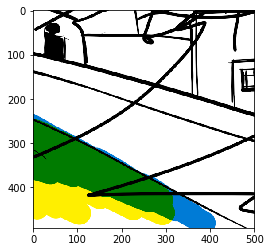

In [4]:
import matplotlib.pyplot as mp
import tensorflow as tf

# 读数据
image_raw_data = tf.gfile.FastGFile('./data/picture.png', 'rb').read()
# print(image_raw_data.shape)
with tf.Session() as sess:
    # 解析数据
    img_data = tf.image.decode_png(image_raw_data)
    print(img_data.eval().shape)
    # 显示图像
    mp.imshow(img_data.eval())
    mp.show()

> ### 图像大小resize

```python
resize_area()
resize_bicubic()
resize_bilinear()
resize_image_with_crop_or_pad()
resize_images()
resize_nearest_neighbor()
```

old--> (492, 501, 4)
new--> (300, 300, 4)


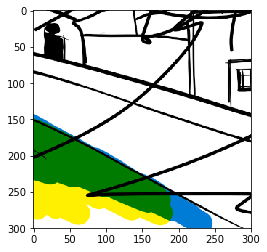

In [10]:
import matplotlib.pyplot as mp
import tensorflow as tf

# 读数据
image_raw_data = tf.gfile.FastGFile('./data/picture.png', 'rb').read()
# print(image_raw_data.shape)
with tf.Session() as sess:
    # 解析数据
    img_data = tf.image.decode_png(image_raw_data)
    print('old-->', img_data.eval().shape)
    
    # 转成tf的float32格式
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    img_data = tf.image.resize_images(img_data, [300, 300], method=0)
    print('new-->', img_data.eval().shape)
    # 显示图像
    mp.imshow(img_data.eval())
    mp.show()

> ### 图像翻转

对图像进行**上下，左右，中心**翻转

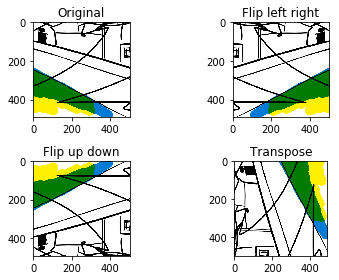

In [51]:
import matplotlib.pyplot as mp
import tensorflow as tf

# 读数据
image_raw_data = tf.gfile.FastGFile('./data/picture.png', 'rb').read()
# print(image_raw_data.shape)
with tf.Session() as sess:
    # 解析数据
    img_data = tf.image.decode_png(image_raw_data)
    
    # 转成tf的float32格式
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    
    mp.subplot(221)
    mp.title('Original')
    mp.imshow(img_data.eval())
    
    mp.subplot(222)
    mp.title('Flip left right')
    img_data_lr = tf.image.flip_left_right(img_data)
    mp.imshow(img_data_lr.eval())
    
    mp.subplot(223)
    mp.title('Flip up down')
    img_data_ud = tf.image.flip_up_down(img_data)
    mp.imshow(img_data_ud.eval())
    
    mp.subplot(224)
    mp.title('Transpose')
    img_data_tr = tf.image.transpose_image(img_data)
    mp.imshow(img_data_tr.eval())
#     print(img_data_tr.eval())
    
    mp.tight_layout()
    mp.show()

> ### 色彩调整

调整图像的**亮度，对比度，饱和度，色相**

```python
# 调整亮度，随机调整亮度
tf.image.adjust_brightness()
tf.image.random_brightness()

# 调整对比度，随机调整对比度
tf.image.adjust_contrast()
tf.image.random_contrast()

# 调整色相
tf.image.adjust_hue()
tf.image.random_hue()

# 调整饱和度
tf.image.adjust_saturation()
tf.image.random_saturation()

# 图像标准化(将图像上的亮度均值变为0，方差变为-1)
tf.image.per_image_standardization()

# 截断操作,用于将值调整到给定范围
tf.clip_by_value()
```

> ### 处理标注框

```python
tf.image.draw_bounding_boxes()
tf.image.sample_distorted_bounding_box() # 随机截取图像
```

old--> (492, 501, 4)
new--> (200, 200, 4)
batch--> (1, 200, 200, 4)
result--> (1, 200, 200, ?)
result--> (200, 200, ?)


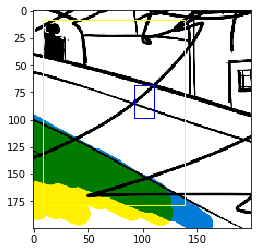

In [69]:
import matplotlib.pyplot as mp
import tensorflow as tf

# 读数据
image_raw_data = tf.gfile.FastGFile('./data/picture.png', 'rb').read()
# print(image_raw_data.shape)
with tf.Session() as sess:
    # 解析数据
    img_data = tf.image.decode_png(image_raw_data)
    print('old-->', img_data.eval().shape)
    
    # 转成tf的float32格式
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    img_data = tf.image.resize_images(img_data, [200, 200], method=1)
    print('new-->', img_data.eval().shape)
    batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0)
    print('batch-->', batched.eval().shape)
#     mp.imshow(img_data.eval())
    boxes = tf.constant([[[0.05,0.05,0.9,0.7],[0.35,0.47,0.5,0.56]]])
    result = tf.image.draw_bounding_boxes(batched, boxes)
    print('result-->', result.shape)
#     tf.slice(result,)
    result = result[0,:,:,:]
    print('result-->', result.shape)
    # 显示图像
#     print(result.eval())
    mp.imshow(result.eval())
    mp.show()

> ### 随机截取图像

In [ ]:
import matplotlib.pyplot as mp
import tensorflow as tf

# 读数据
image_raw_data = tf.gfile.FastGFile('./data/picture.png', 'rb').read()
# print(image_raw_data.shape)
with tf.Session() as sess:
    # 解析数据
    img_data = tf.image.decode_png(image_raw_data)
    print('old-->', img_data.eval().shape)
    
    # 转成tf的float32格式
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    img_data = tf.image.resize_images(img_data, [200, 200], method=1)
    print('new-->', img_data.eval().shape)
    batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0)
    print('batch-->', batched.eval().shape)
#     mp.imshow(img_data.eval())
    boxes = tf.constant([[[0.05,0.05,0.9,0.7],[0.35,0.47,0.5,0.56]]])
    result = tf.image.draw_bounding_boxes(batched, boxes)
    print('result-->', result.shape)
#     tf.slice(result,)
    result = result[0,:,:,:]
    print('result-->', result.shape)
    # 显示图像
#     print(result.eval())
    mp.imshow(result.eval())
    mp.show()

old--> (237, 257, 4)
new--> (300, 300, 4)
[30  9  0]
[127 164  -1]
[[[0.20333333 0.03       0.9766667  0.85      ]]]


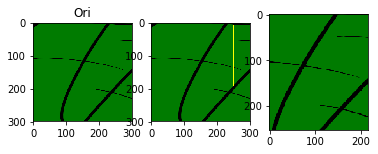

In [1]:
import matplotlib.pyplot as mp
import tensorflow as tf

# 读数据
image_raw_data = tf.gfile.FastGFile('./data/picture1.png', 'rb').read()
# print(image_raw_data.shape)
with tf.Session() as sess:
    # 解析数据
    img_data = tf.image.decode_png(image_raw_data)
    print('old-->', img_data.eval().shape)

    # 转成tf的float32格式
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    img_data = tf.image.resize_images(img_data, [300, 300], method=1)
    print('new-->', img_data.eval().shape)

    # 增加一维到四维，第一维为batch
    batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0)
    # 设定框选区域，即标注有用区域
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7]]])
    ori = tf.image.draw_bounding_boxes(batched, boxes)
    mp.subplot(131)
    mp.title('Ori')
    mp.imshow(ori.eval()[0, ...])

    # 随机区域框，要包含上述标注区域的0.4
    begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(tf.shape(img_data),
                                                                        bounding_boxes=boxes,
                                                                        min_object_covered=0.4)
    image_with_box = tf.image.draw_bounding_boxes(ori, bbox_for_draw)
    # 画出选取的区域
    mp.subplot(132)
    mp.imshow(image_with_box.eval()[0, ...])

    # 最终截取区域
    distorted_image = tf.slice(img_data, begin, size)
    print(begin.eval())
    print(size.eval())
    print(bbox_for_draw.eval())
    mp.subplot(133)
    mp.imshow(distorted_image.eval())
    mp.show()

## 7.2 图像预处理完整样例
---
```python

def distort_color(image, color_ordering=0):
    # 设定多个调整亮度，对比度，色相，饱和度的排序，并随机选择一种
    # 进行图像调整，最后规范数据范围
    pass

def preprocess_for_train(image, height, width, bbox):
    # 给定图像，输入大小，标注范围
    # 对image进行格式调整
    # 获取随机框
    # 截取随机框
    # 按照给定输出大小，对图像进行resize
    # 左右，上下resize
    # 调用distort_color()进行图像调整
    # 返回image
    
```

## 7.3 多线程输入数据处理框架
---
### 7.3.1 队列及多线程
---
1. tf中提供了两种队列的实现方式

```python
tf.FIFOQueue()
tf.RandomShuffleQueue()
```

2. tf中提供了两个类来实现多线程协同的功能。

```python
tf.train.Coordinator()
tf.train.QueueRunner()
```

In [5]:
# 队列
import tensorflow as tf

q = tf.FIFOQueue(2, 'int32')
init = q.enqueue_many(([0, 10],))
x = q.dequeue()
y = x + 1
q_inc = q.enqueue([y])

with tf.Session() as sess:
    init.run()
    for _ in range(5):
        v, _ = sess.run([x, q_inc])
        print(v)

0
10
1
11
2



### 多线程

**Coordinator主要用于协同多个线程一起停止**
```python
# 不要在notebook中执行，
import threading
import time
import tensorflow as tf
import numpy as np

def func(coor, i):
    while not coor.should_stop():
        if np.random.rand() < 0.1:
            print('Stoping from id : %d\n' % i)
            coor.request_stop()
        else:
            print('Working on id: %d\n' % i)
        time.sleep(1)

coor = tf.train.Coordinator()
threads = [threading.Thread(target=func, args=(coor, i)) for i in range(5)]
for t in threads:
    t.start()
coor.join(threads)

```

**QueueRunner主要用于启动多个线程执行操作同一个队列，启动的这些线程可以通过Coordinator来统一管理**
```python
import tensorflow as tf

# 创建一个先进先出的队列
queue = tf.FIFOQueue(10, 'float')

# 获取一个随机正太分布的数，执行进队操作。
enqueue_op = queue.enqueue([tf.random_normal([1])])

# 创建五个线程执行入队操作
qr = tf.train.QueueRunner(queue, [enqueue_op] * 5)

tf.train.add_queue_runner(qr)

# 定义出队操作
out_tensor = queue.dequeue()

with tf.Session() as sess:
    coor = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coor)
    for _ in range(3):
        print(sess.run(out_tensor))

    coor.request_stop()
    coor.join(threads)
```

### 7.3.2 输入文件队列
---
```python
tf.train.match_filenames_once()
tf.train.string_input_producer()
```
> **样例生成**

In [7]:
import tensorflow as tf

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 定义文件的个数
num_shards = 2

# 定义每个文件有多少个数据
instance_per_shard = 2

for i in range(num_shards):
    filename = './tfrecord/data-%.5d-of-%.5d' % (i, num_shards)
    writer = tf.python_io.TFRecordWriter(filename)
    for j in range(instance_per_shard):
        example = tf.train.Example(features=tf.train.Features(feature={
            'i': _int64_feature(i),
            'j': _int64_feature(j)
        }))
        writer.write(example.SerializeToString())
    writer.close()

ERROR! Session/line number was not unique in database. History logging moved to new session 290


> **从多个tfrecord读取数据**

```python
tf.train.match_filenames_once() # 获取文件列表
tf.train.string_input_producer() # 创建输入队列
```
放在队列中的数据如果读完，会从头开始，可以通过设置`num_epochs`属性开限制轮读次数

In [19]:
import tensorflow as tf

# 获取文件列表,需要初始化
files = tf.train.match_filenames_once('./tfrecord/data-*')

# 创建输入队列
filename_queue = tf.train.string_input_producer(files, shuffle=False)

# 创建reader
reader = tf.TFRecordReader()

# 读取文件列表
_, serialized_example = reader.read(filename_queue)

# 解析每个feature
features = tf.parse_single_example(serialized_example, features={
    'i': tf.FixedLenFeature([], tf.int64),
    'j': tf.FixedLenFeature([], tf.int64)
})

with tf.Session() as sess:
    tf.local_variables_initializer().run()
    
    print(sess.run(files))
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    for i in range(6):
        print(sess.run([features['i'], features['j']]))
    
    coord.request_stop()
    coord.join(threads)

[b'.\\tfrecord\\data-00000-of-00002' b'.\\tfrecord\\data-00001-of-00002']
[0, 0]
[0, 1]
[1, 0]
[1, 1]
[0, 0]
[0, 1]


### 7.3.3 组合训练数据(batching)
---
```python
tf.train.batch()
tf.train.shuffle_batch()
```
这两个函数都会生成一个队列，队列的入队操作是生成单个样例的方法，而每次出对是一个batch的样例。

In [1]:
import tensorflow as tf

files = tf.train.match_filenames_once('./tfrecord/data-*')
filename_queue = tf.train.string_input_producer(files)

reader = tf.TFRecordReader()
_, serialize_example = reader.read(filename_queue)

features = tf.parse_single_example(serialize_example, features={
    'i': tf.FixedLenFeature([], tf.int64),
    'j': tf.FixedLenFeature([], tf.int64)
})

example, label = features['i'], features['j']

# 定义batch大小，
batch_size = 3
capacity = 1000 + 3 * batch_size

example_batch, label_batch = tf.train.batch([example, label], batch_size=batch_size, capacity=capacity)

with tf.Session() as sess:
    tf.local_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    # 输出两个batch,共六个数据
    for i in range(2):
        examples, labels = sess.run([example_batch, label_batch])
        print(examples, labels)
    
    coord.request_stop()
    coord.join(threads)

[0 0 1] [0 1 0]
[1 0 0] [1 0 1]


### 7.3.4 输入数据处理框架 
---

## 7.4 Dataset
---
### 7.4.1 数据集的basic
---
常用的数据来源有：tensor, TFRecord, txt ...
1. 定义数据集的构造方法
    - tf.data.Dataset
    - tf.data.TextLineDataset
    - tf.data.TFRecordDataset
2. 定义遍历器
3. 使用`get_next()`

In [3]:
import tensorflow as tf

input_data = [1, 2, 3, 5, 8]

dataset = tf.data.Dataset.from_tensor_slices(input_data)

iterator = dataset.make_one_shot_iterator()

x = iterator.get_next()
y = x ** 2

with tf.Session() as sess:
    for i in range(len(input_data)):
        print(sess.run(y))

1
4
9
25
64


# 8 循环神经网络
---


In [1]:
import numpy as np
import tensorflow as tf

In [5]:
tf.data.Dataset
tf.data.TextLineDataset
tf.data.TFRecordDataset

In [16]:
sess = tf.InteractiveSession()

In [7]:
import tensorflow as tf

In [17]:
indices = tf.expand_dims(tf.range(0, 10, 1), 1)

In [18]:
sess.run(indices)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [19]:
tf.sparse_to_dense?